<a href="https://colab.research.google.com/github/ivelin/donut_ui_refexp/blob/main/Donut_Click_Fine_tune_Donut_on_UI_RefExp_Center.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Donut 🍩 on UI RefExp - Center Mass/Click Point Prediction

> _NOTE_: This notebook is based on the [Fine-tuning Donut for RefExp notebook](https://github.com/ivelin/donut_ui_refexp/blob/main/Fine_tune_Donut_on_UI_RefExp.ipynb). 

In this notebook, we'll fine-tune [Donut](https://huggingface.co/docs/transformers/model_doc/donut) on predicting the __center point__ of a UI component based on a natural language Referring Expression.


In [65]:
#@title load local env vars such as secret API tokens
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [66]:
import os
WANDB_TOKEN=os.environ.get('WANDB_TOKEN')
HUGGING_FACE_HUB_TOKEN=os.environ.get('HUGGING_FACE_HUB_TOKEN')


In [67]:
#@title Let's install required dependencies

!pip install -q git+https://github.com/huggingface/transformers.git

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [68]:
!pip install -q datasets sentencepiece

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [69]:
!pip install -q pytorch-lightning wandb

Keyring is skipped due to an exception: 'keyring.backends'


In [70]:
#@title Let's see what system resources we are running on
import os
print(f"CPU Count: {os.cpu_count()}")

CPU Count: 2


In [71]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [73]:
import torch

def cpu():
    return torch.device('cpu')
def gpu(i=0):
    return torch.device(f'cuda:{i}')
cpu(), gpu(), gpu(1)

ModuleNotFoundError: No module named 'torch'

In [74]:

def num_gpus():
    return torch.cuda.device_count()
num_gpus()

NameError: name 'torch' is not defined

In [75]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 4.1 gigabytes of available RAM

Not using a high-RAM runtime


In [76]:
#@title Login to HuggingFace hub so we can save our trained model checkpoints
# !huggingface-cli login
import huggingface_hub
huggingface_hub.login(HUGGING_FACE_HUB_TOKEN)


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [77]:
#@title Login to Weights&Biases so we can log and chart our training metrics
import wandb

wandb.login(key=WANDB_TOKEN)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load dataset

Next, let's load the dataset from the [hub](https://huggingface.co/datasets/ivelin/rico_refexp_combined). We're prepared a RICO based dataset with combined synthetic and crowdsourced UI referring expressions. The first 15K samples in the dataset are crowdsourced. The rest of the 350K samples are synthetically generated.


In [78]:
REFEXP_DATASET_NAME = "ivelin/ui_refexp_saved"

# Pick which pretrained checkpoint to start the fine tuning process from
REFEXP_MODEL_CHECKPOINT = "ivelin/donut-refexp-click"
REFEXP_MODEL_CP_BRANCH = 'main' 
# revision: '348ddad8e958d370b7e341acd6050330faa0500f' # Iou = 0.47
# revision: '41210d7c42a22e77711711ec45508a6b63ec380f'# : IoU=0.42 # 
# use 'main' for latest revision

# REFEXP_MODEL_CHECKPOINT = "ivelin/donut-refexp-draft"
# REFEXP_MODEL_CHECKPOINT = "naver-clova-ix/donut-base"
# REFEXP_MODEL_CHECKPOINT = "ivelin/donut-docvqa-demo"


In [79]:
from datasets import load_dataset

dataset = load_dataset(REFEXP_DATASET_NAME, num_proc=8)

Using custom data configuration ivelin--ui_refexp_saved-6916d19d5dad9975
Found cached dataset parquet (/root/.cache/huggingface/datasets/ivelin___parquet/ivelin--ui_refexp_saved-6916d19d5dad9975/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

As can be seen, the dataset contains a training, a validation and a test split. And each example consists of an image, a prompt, and a target bounding box.

In [80]:
print(dataset['train'].info)
print(dataset)


DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(decode=True, id=None), 'image_id': Value(dtype='string', id=None), 'image_file_path': Value(dtype='string', id=None), 'prompt': Value(dtype='string', id=None), 'target_bounding_box': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, config_name=None, version=None, splits={'validation': SplitInfo(name='validation', num_bytes=60409431, num_examples=471, shard_lengths=None, dataset_name='parquet'), 'train': SplitInfo(name='train', num_bytes=1911005765, num_examples=15624, shard_lengths=[3906, 3906, 3906, 3906], dataset_name='parquet'), 'test': SplitInfo(name='test', num_bytes=69086257, num_examples=565, shard_lengths=None, dataset_name='parquet')}, download_checksums={'https://huggingface.co/datasets/ivelin/ui_refexp_saved/resolve/38a258997cb5e6dd9b973534d3f860e76a6936a5/data/validation-00000-of-00001-08fa3b28509964a2.parquet': {'num_

sample {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1920 at 0x7EFF10AC4450>, 'image_id': '51807', 'image_file_path': 'combined/51807.jpg', 'prompt': 'click on down arrow beside the entertainment', 'target_bounding_box': '{"xmin": 0.6796296238899231, "ymin": 0.4906249940395355, "xmax": 0.8296296000480652, "ymax": 0.5041666626930237}'}
image width, height: (1080, 1920)
prompt: click on down arrow beside the entertainment
target bounding box: {'xmin': 0.6796296238899231, 'ymin': 0.4906249940395355, 'xmax': 0.8296296000480652, 'ymax': 0.5041666626930237}
to image pixel values: xmin, ymin, xmax, ymax: (733, 941, 895, 967)
resized image width, height: (720, 1280)


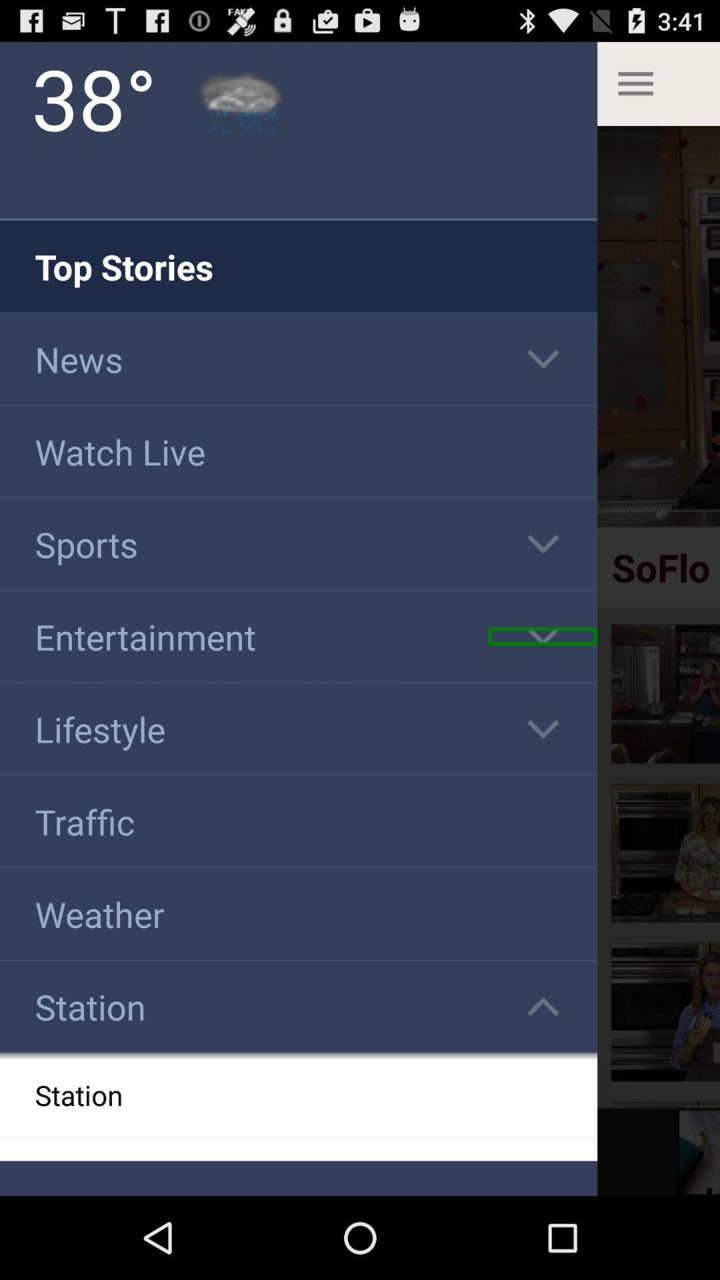

In [82]:
#@title Let's look at a sample in the dataset
import math
import json
from PIL import Image, ImageDraw

# change this index from 0 to split size to see different samples
sample = dataset['train'][1]
image = sample['image']
width, height = image.size
print('sample', sample)
print(f"image width, height: {width, height}")
print(f"prompt: {sample['prompt']}")

# bb = json.loads(sample["target_bounding_box"])
bb = sample["target_bounding_box"]
if isinstance(bb, str):
  bb = json.loads(bb) 

print(f"target bounding box: {bb}")

xmin = math.floor(width*bb["xmin"])
ymin = math.floor(height*bb["ymin"])
xmax = math.floor(width*bb["xmax"])
ymax = math.floor(height*bb["ymax"])

print(f"to image pixel values: xmin, ymin, xmax, ymax: {xmin, ymin, xmax, ymax}")

shape = [(xmin, ymin), (xmax, ymax)]

# create rectangle image
img1 = ImageDraw.Draw(image)  
img1.rectangle(shape, outline ="green", width=5)
image.thumbnail((960, 1280))
width, height = image.size
print(f"resized image width, height: {width, height}")
image

## Load model and processor

Next, we load the model (which is an instance of [VisionEncoderDecoderModel](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder), and the processor, which is the object that can be used to prepare inputs for the model.

In [83]:
from transformers import VisionEncoderDecoderConfig

pretrained_repo_name = REFEXP_MODEL_CHECKPOINT
pretrained_repo_branch = REFEXP_MODEL_CP_BRANCH

# max length of predicted decoder text sequence 
max_length = 128
# normalized input image size (height, width)
encoder_image_size = [1280, 960]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained(pretrained_repo_name, branch=pretrained_repo_branch, use_auth_token=HUGGING_FACE_HUB_TOKEN)
config.encoder.image_size = encoder_image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [84]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained(pretrained_repo_name, revision=pretrained_repo_branch, use_auth_token=HUGGING_FACE_HUB_TOKEN)
model = VisionEncoderDecoderModel.from_pretrained(pretrained_repo_name, revision=pretrained_repo_branch, config=config, use_auth_token=HUGGING_FACE_HUB_TOKEN)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ImportError: 
VisionEncoderDecoderModel requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


## Add special tokens

For RefExp, we add special tokens for \<prompt> \<target_center>, \<x>, and \<y>, to make sure that the model (actually the decoder) learns embedding vectors for those explicitly.

In [19]:
from typing import List

def add_tokens(list_of_tokens: List[str]):
    """
    Add tokens to tokenizer and resize the token embeddings
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
        model.decoder.resize_token_embeddings(len(processor.tokenizer))

## Create PyTorch dataset

Here we create a regular PyTorch dataset.

The model doesn't directly take the (image, JSON) pairs as input and labels. Rather, we create `pixel_values`, `decoder_input_ids` and `labels`. These are all PyTorch tensors. The `pixel_values` are the input images (resized, padded and normalized), the `decoder_input_ids` are the decoder inputs, and the `labels` are the decoder targets.

The reason we create the `decoder_input_ids` explicitly here is because otherwise, the model would create them automatically based on the `labels` (by prepending the decoder start token ID, replacing -100 tokens by padding tokens). The reason for that is that we don't want the model to learn to generate the entire prompt, which includes the question. Rather, we only want it to learn to generate the answer. Hence, we'll set the labels of the prompt tokens to -100.



In [20]:
def validate_bbox(bb):
  """
  Ensures correct coordinates for bounding box. Returns true
  Returns
  -------
  True if bbox coordinates are valid. False otherwise.
  """
  try:
    if bb['xmin'] > bb['xmax']:
      return False
    if bb['ymin'] > bb['ymax']:
      return False
  except Exception as e:
    print(f"Invalid bbox: {bb}", e)
    return False 
  return True

def bbox_center_point(bb):
  if validate_bbox(bb):
    # determine the coordinates of the center of each rectangle
    bb_x_center = (bb['xmax'] + bb['xmin'])/2
    bb_y_center = (bb['ymax'] + bb['ymin'])/2
    cp = {'x': bb_x_center, 'y': bb_y_center}
  else:
    cp = {'x': 0, 'y': 0}
  return cp

In [4]:
def translate_point_coords_to_tensor_image_size(point=None, input_image_size=None, output_image_size=None):
    """
    Convert relative coordinates to resized tensor image
    taking into account padding space.
    Args:
        original_point: x, y coordinates of the point coordinates in [0..1] range in the original image 
        input_image_size: (width, height) tuple
        output_image_size: (width, height) tuple
    """    
    assert point is not None
    assert input_image_size is not None
    assert output_image_size is not None
    print(f"point={point}, input_image_size={input_image_size}, output_image_size={output_image_size}")
    input_width, input_height = input_image_size
    output_width, output_height = output_image_size
    
    ratio = min(output_width/input_width, output_height/input_height)
    
    resized_height = int(input_height*ratio)
    print(f'>>> resized_height={resized_height}')
    resized_width = int(input_width*ratio)
    print(f'>>> resized_width={resized_width}')

    if resized_height == input_height and resized_width == input_width:
        return

    # translation of the relative positioning is only needed for dimentions that have padding
    if resized_width < output_width:
        # adjust for padding pixels
        point['x'] *= (resized_width / output_width)
    if resized_height < output_height:
        # adjust for padding pixels
        point['y'] *= (resized_height / output_height)
    print(f"translated point={point}, resized_image_size: {resized_width, resized_height}")
        

# let's test the translation math above
out_size=(960, 1280) # height, width
apoint = {'x': 0, 'y': 0}
translate_point_coords_to_tensor_image_size(point=apoint, input_image_size=(10,10), output_image_size=out_size)
assert apoint['x'] == 0 and apoint['y'] == 0
translate_point_coords_to_tensor_image_size(point=apoint, input_image_size=(1000,1000), output_image_size=out_size)
assert apoint['x'] == 0 and apoint['y'] == 0
apoint = {'x': 1, 'y': 1}
in_size=(1000,1000)
translate_point_coords_to_tensor_image_size(point=apoint, input_image_size=in_size, output_image_size=out_size)
assert apoint['x'] == 1 and apoint['y'] == out_size[0]/out_size[1]
apoint = {'x': 1, 'y': 1}
translate_point_coords_to_tensor_image_size(point=apoint, input_image_size=(10,10), output_image_size=out_size)
assert apoint['x'] == 1 and apoint['y'] == out_size[0] / out_size[1]
apoint = {'x': 1, 'y': 1}
translate_point_coords_to_tensor_image_size(point=apoint, input_image_size=out_size, output_image_size=out_size)
assert apoint['x'] == 1 and apoint['y'] == 1
apoint = {'x': 0.5, 'y': 0.5}
in_size=(540,960)
translate_point_coords_to_tensor_image_size(point=apoint, input_image_size=in_size, output_image_size=out_size)
assert apoint['x'] == 0.5 * 720 / out_size[0] and apoint['y'] == 0.5
in_size=(1080, 1920)
translate_point_coords_to_tensor_image_size(point=apoint, input_image_size=out_size, output_image_size=out_size)
assert apoint['x'] == 0.5*720/out_size[0] and apoint['y'] == 0.5




point={'x': 0, 'y': 0}, input_image_size=(10, 10), output_image_size=(960, 1280)
>>> resized_height=960
>>> resized_width=960
translated point={'x': 0, 'y': 0.0}, resized_image_size: (960, 960)
point={'x': 0, 'y': 0.0}, input_image_size=(1000, 1000), output_image_size=(960, 1280)
>>> resized_height=960
>>> resized_width=960
translated point={'x': 0, 'y': 0.0}, resized_image_size: (960, 960)
point={'x': 1, 'y': 1}, input_image_size=(1000, 1000), output_image_size=(960, 1280)
>>> resized_height=960
>>> resized_width=960
translated point={'x': 1, 'y': 0.75}, resized_image_size: (960, 960)
point={'x': 1, 'y': 1}, input_image_size=(10, 10), output_image_size=(960, 1280)
>>> resized_height=960
>>> resized_width=960
translated point={'x': 1, 'y': 0.75}, resized_image_size: (960, 960)
point={'x': 1, 'y': 1}, input_image_size=(960, 1280), output_image_size=(960, 1280)
>>> resized_height=1280
>>> resized_width=960
point={'x': 0.5, 'y': 0.5}, input_image_size=(540, 960), output_image_size=(960, 1

In [21]:
import json
import random
from typing import Any, List, Tuple
import weakref

import torch
from torch.utils.data import Dataset

added_tokens = []

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image blob, prompt and target bounding box.,
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        range_samples: int = None,
        shuffle: bool = False,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)

        self.gt_token_sequences = []
        if shuffle:
          self.dataset = self.dataset.shuffle()
        if range_samples is not None:
          self.dataset = self.dataset.select(range_samples)
        self.dataset = self.dataset.shuffle()
        self.dataset_length = self.dataset.num_rows
        # create an in-memory cache for pixel tensors
        self.pixel_cache = weakref.WeakValueDictionary()
        # create an in-memory cache for input_ids
        self.input_ids_cache = weakref.WeakValueDictionary()
        for sample in self.dataset:
            prompt = sample["prompt"]
            # bb = json.loads(sample["target_bounding_box"])
            bb = sample["target_bounding_box"]
            if isinstance(bb, str):
              bb = json.loads(bb)             
            cp = bbox_center_point(bb)
            # Trim float precision to simplify training with shorter string representations of component coordinates.
            # 2 decimals precision seems to be a good balance between component position acccuracy and model convergance time.
            # 3 decimals precision is good enough for screenshot size up to [1000x1000], but it takes longer for the model to converge.
            # For even finer granurality, we cam increase precision to 4 for [10,000 x 10,000] screen sizes, but it will take much more training time and compute resources to converge.
            for key, value in cp.items():
              cp[key] = round(value,2)

            
            # convert relative coordinates to resized tensor image
            # taking into account padding space
            translate_point_coords_to_tensor_image_size(point=cp, input_image_size=sample['image'].size, output_image_size=(processor.size[0], processor.size[1]))
            
            assert isinstance(cp, dict)
            ground_truth = {"prompt": prompt, "target_center": cp}
            gt_json = ground_truth

            j2t = self.json2token(
                  gt_json,
                  update_special_tokens_for_json_key=self.split == "train",
                  sort_json_key=self.sort_json_key,
              ) + processor.tokenizer.eos_token
            self.gt_token_sequences.append(j2t)

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length - 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # input_tensor
        input_tensor = self.pixel_cache.get(idx)
        if input_tensor is None:
          pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
          input_tensor = pixel_values.squeeze()
          self.pixel_cache[idx] = input_tensor
        # elif idx % 100 == 0:
        #   print(f'{self.split} dataloader pixel_cache hit at index {idx}')

        # input_ids
        input_ids = self.input_ids_cache.get(idx)
        if input_ids is None:
          processed_parse = self.gt_token_sequences[idx]
          input_ids = processor.tokenizer(
              processed_parse,
              add_special_tokens=False,
              max_length=self.max_length,
              padding="max_length",
              truncation=True,
              return_tensors="pt",
          )["input_ids"].squeeze(0)
          self.input_ids_cache[idx] = input_ids
        # elif idx % 100 == 0:
        #   print(f'{self.split} dataloader input_ids cache hit at index {idx}')


        if idx % 200 == 0:
          print(f"sameple #{idx}, input_ids: {input_ids}")

        if self.split == "train":
            labels = input_ids.clone()
            labels[
                labels == processor.tokenizer.pad_token_id
            ] = self.ignore_id  # model doesn't need to predict pad token
            labels[
                : torch.nonzero(labels == self.prompt_end_token_id).sum() + 1
            ] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
            return input_tensor, input_ids, labels
        else:
            prompt_end_index = torch.nonzero(
                input_ids == self.prompt_end_token_id
            ).sum()  # return prompt end index instead of target output labels
            return input_tensor, input_ids, prompt_end_index, processed_parse

In [22]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['image', 'image_id', 'image_file_path', 'prompt', 'target_bounding_box'],
        num_rows: 471
    })
    train: Dataset({
        features: ['image', 'image_id', 'image_file_path', 'prompt', 'target_bounding_box'],
        num_rows: 15624
    })
    test: Dataset({
        features: ['image', 'image_id', 'image_file_path', 'prompt', 'target_bounding_box'],
        num_rows: 565
    })
})

In [23]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.image_processor.size = encoder_image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False
# do not resize in a way that may crop the original image
processor.image_processor.do_resize = False
# do resize in a way that will fit the original image entirely without cropping out any section of it
processor.image_processor.do_thumbnail = True


# For warm up phase, consider picking only a small subset to see if the model converges on the data
max_train_samples = 1 # 5624
# pick a range for sampling
# range_train_samples = range(4000, 4000+max_train_samples)
range_train_samples = range(max_train_samples)

train_dataset = DonutDataset(REFEXP_DATASET_NAME, max_length=max_length, 
                             range_samples=range_train_samples,
                             shuffle=True,
                             split="train", task_start_token="<s_refexp>", prompt_end_token="<s_target_center>",
                             sort_json_key=False,
                             )



/opt/conda/lib/python3.7/site-packages/transformers/models/donut/processing_donut.py:188: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  FutureWarning,
Using custom data configuration ivelin--ui_refexp_saved-6916d19d5dad9975
Found cached dataset parquet (/root/.cache/huggingface/datasets/ivelin___parquet/ivelin--ui_refexp_saved-6916d19d5dad9975/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [24]:
train_dataset[0]



sameple #0, input_ids: tensor([57527, 18539, 48941, 49551,  9343, 45954, 51509, 57528, 57546, 57542,
        50891, 39539, 14850, 57543, 57544, 50891, 39539,  3200, 57545, 57547,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor([57527, 18539, 48941, 49551,  9343, 45954, 51509, 57528, 57546, 57542,
   

In [25]:

# pick a small subset for initial val set to see if validation metrics improve
max_val_samples = 1 # 471
range_val_samples = range(max_val_samples)
# range_val_samples = range(0,max_val_samples,8)

val_dataset = DonutDataset(REFEXP_DATASET_NAME, max_length=max_length, range_samples=range_val_samples,
                             split="validation", task_start_token="<s_refexp>", prompt_end_token="<s_target_center>",
                             sort_json_key=False,
                             )


Using custom data configuration ivelin--ui_refexp_saved-6916d19d5dad9975
Found cached dataset parquet (/root/.cache/huggingface/datasets/ivelin___parquet/ivelin--ui_refexp_saved-6916d19d5dad9975/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [26]:
pixel_values, decoder_input_ids, labels = train_dataset[0]


sameple #0, input_ids: tensor([57527, 18539, 48941, 49551,  9343, 45954, 51509, 57528, 57546, 57542,
        50891, 39539, 14850, 57543, 57544, 50891, 39539,  3200, 57545, 57547,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1

In [27]:
pixel_values.shape

torch.Size([3, 1280, 960])

In [28]:
print(labels)

tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100, 57542,
        50891, 39539, 14850, 57543, 57544, 50891, 39539,  3200, 57545, 57547,
            2,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])

In [29]:
for decoder_input_id, label in zip(decoder_input_ids.tolist()[:-1], labels.tolist()[1:]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_prompt> -100
click -100
the -100
right -100
bot -100
tom -100
button -100
</s_prompt> -100
<s_target_center> <s_x>
<s_x> 0
0 .
. 74
74 </s_x>
</s_x> <s_y>
<s_y> 0
0 .
. 9
9 </s_y>
</s_y> </s_target_center>
</s_target_center> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -10

In [30]:
pixel_values, decoder_input_ids, prompt_end_index, processed_parse = val_dataset[0]


sameple #0, input_ids: tensor([57527, 18539, 56738, 48941, 42303, 36306, 52743, 38432, 48941, 42990,
        28732, 56980, 48941,  9343, 45954,  2587, 48941, 55435, 57528, 57546,
        57542, 50891, 39539, 35934, 57543, 57544, 50891, 39539,  5082, 57545,
        57547,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1

In [31]:
pixel_values.shape

torch.Size([3, 1280, 960])

In [32]:
prompt_end_index

tensor(19)

In [33]:
processed_parse

'<s_prompt>click on the icon which is above the wed at the bottom of the page</s_prompt><s_target_center><s_x>0.2</s_x><s_y>0.82</s_y></s_target_center></s>'

## Create PyTorch DataLoaders

Next, we create corresponding PyTorch DataLoaders.

In [34]:
print(f"train dataset length: {train_dataset.dataset_length}")
print(f"validation dataset length: {val_dataset.dataset_length}")


train dataset length: 15624
validation dataset length: 471


In [35]:
# torch.cuda.empty_cache()

In [36]:
#@title Set optimal batch size for training and validation 
# Currently there is an issue with VisualEncoderDecoder when batch size > 1
# Causes error in loss calculation during training
train_batch_size = 1 # Usually increments of 8. Value depends on GPU capacity.
print(f"train_batch_size: {train_batch_size}")
val_batch_size = 1

train_batch_size: 1


In [37]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Let's verify a batch:

In [38]:
batch = next(iter(train_dataloader))
pixel_values, decoder_input_ids, labels = batch
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


In [39]:
decoder_input_ids.shape

torch.Size([1, 128])

We can clearly see that we have set the labels of all prompt tokens (which includes the prompt) to -100, to make sure the model doesn't learn to generate them. We only start to have labels starting from the \<s_target_center> decoder input token.

In [40]:
for decoder_input_id, label in zip(decoder_input_ids[0].tolist()[:-1][:50], labels[0].tolist()[1:][:50]):
  if label != -100:
    print(processor.decode([decoder_input_id]), processor.decode([label]))
  else:
    print(processor.decode([decoder_input_id]), label)

<s_prompt> -100
select -100
the -100
image -100
of -100
vin -100
ny -100
s -100
f -100
85 -100
31 -100
7 -100
mi -100
</s_prompt> -100
<s_target_center> <s_x>
<s_x> 0
0 .
. 75
75 </s_x>
</s_x> <s_y>
<s_y> 0
0 .
. 71
71 </s_y>
</s_y> </s_target_center>
</s_target_center> </s>
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100


## Define LightningModule

We'll fine-tune the model using [PyTorch Lightning](https://www.pytorchlightning.ai/) here, but note that you can of course also just fine-tune with regular PyTorch, HuggingFace [Accelerate](https://github.com/huggingface/accelerate), the HuggingFace [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer), etc.

PyTorch Lightning is pretty convenient to handle things like device placement, mixed precision and logging for you.

### Defining Evaluation Metric




#### Distance between target centers

An intuitive eval metric is to measure the distance in center coordinates between prediction and ground truth.



In [41]:
import math

def validate_point(point):
  """
  Ensures correct coordinates for point.
  Returns True if valid, False otherwise.
  -------
  True if coordinates are valid. False otherwise.
  """
  try:
    if float(point['x']) > 1 or float(point['x']) < 0:
      return False
    if float(point['y']) > 1 or float(point['y']) < 0:
      return False
  except Exception as e:
    print(f"Invalid point coordinates: {point}", e)
    return False 
  return True

def get_center_distance(point1, point2):
    """
    Calculate the distance between two points.
    Best case, distance between centers of predicted and ground truth is 0.
    Worst case,  distance will be the larges diagonal ofn the screen: sqrt(1,1).

    Parameters
    ----------
    point1 : dict
        Keys: {'x', 'y'}
    point2 : dict
        Keys: {'x', 'y'}

    Returns
    -------
    float
        in [0, sqrt(1+1)]
    """
    # print(f"get_center_distance point1: {point1}, point2: {point2}")
    best_case = 0.0
    worst_case = math.sqrt(1+1) # max diagonal
    # make sure prediction and labels are valid
    if not validate_point(point1) or not validate_point(point2):
      return worst_case

    # determine the coordinates of the center of each rectangle
    center_dist = math.sqrt((point1['x'] - point2['x'])**2 + (point1['y'] - point2['y'])**2)
    # print(f"get_center_distance center_dist: {center_dist}")

    assert center_dist >= best_case
    assert center_dist <= worst_case
    return center_dist

### Donut Lightning Module

In [42]:
from pathlib import Path
import re
# from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only


class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model
        self.batch_size = train_batch_size
        self.learning_rate = self.config.get("lr")        
        # self.log_dict(config)

    def training_step(self, batch, batch_idx):
        pixel_values, decoder_input_ids, labels = batch
        
        outputs = self.model(pixel_values,
                             decoder_input_ids=decoder_input_ids[:, :-1],
                             labels=labels[:, 1:])
        loss = outputs.loss
        self.log_dict({"train_loss": loss}, sync_dist=True)
        return loss

    def token2point(self, seq: str):
        # print(f"token2point seq: {seq}")
        target_center = self.processor.token2json(seq)
        center_point = target_center.get('target_center')
        if center_point is None:
          # print(f"target_center json: {target_center} has no s_target_center attribute, seq:{seq}")
          point = {"x": 0, "y": 0}
          return point
        # safeguard in case text prediction is missing some coordinates
        # or coordinates are not valid numeric values
        try:
          x = float(center_point.get("x", 0))
        except Exception:
          x = -1 # invalid cooridates
        try:
          y = float(center_point.get("y", 0))
        except Exception:
          y = -1 # invalid coordinates
        # replace str with float coords
        point = {"x": x, "y": y}
        # print(f"token2 center_point float: {center_point}")
        # print(f"token2point point: {point}")
        return point

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, decoder_input_ids, prompt_end_idxs, answers = batch
        decoder_prompts = pad_sequence(
            [input_id[: end_idx + 1] for input_id, end_idx in zip(decoder_input_ids, prompt_end_idxs)],
            batch_first=True,
        )
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_prompts,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = list()
        for pred, answer in zip(predictions, answers):
            answer = re.sub(r"<.*?>", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            # print(f"predictoin seq: {pred}\n answer seq: {answer}")
            answer_point = self.token2point(answer)
            pred_point = self.token2point(pred)
            scores.append(get_center_distance(pred_point, answer_point))
            if self.config.get("verbose", False) and len(scores) == 1:
              print(f"      Prediction seq: {pred}")
              print(f"          Answer seq: {answer}")
              print(f" Prediction point: {pred_point}")
              print(f"     Answer point: {answer_point}")
              print(f"Eval score (Center Distance): {scores[0]}")

        return scores

    def validation_epoch_end(self, validation_step_outputs):
        # I set this to 1 manually
        # (previously set to len(self.config.dataset_name_or_paths))
        num_of_loaders = 1
        if num_of_loaders == 1:
            validation_step_outputs = [validation_step_outputs]
        assert len(validation_step_outputs) == num_of_loaders
        cnt = [0] * num_of_loaders
        total_metric = [0] * num_of_loaders
        val_metric = [0] * num_of_loaders
        for i, results in enumerate(validation_step_outputs):
            for scores in results:
                cnt[i] += len(scores)
                total_metric[i] += np.sum(scores)
            val_metric[i] = total_metric[i] / cnt[i]
            val_metric_name = f"val_metric_{i}th_dataset"
            self.log_dict({val_metric_name: val_metric[i]}, sync_dist=True)
        self.log_dict({"val_metric": np.sum(total_metric) / np.sum(cnt)}, sync_dist=True)

    def configure_optimizers(self):
        # https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html?highlight=configure_optimizers#configure-optimizers
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
        # we use max below, because we want the lr to decrease if IoU stops increasing
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2) # previously patience=3, 5
        # log initial value for val_metric to avoid train error before its calculated
        # self.log_dict({"val_metric": 0.0}, sync_dist=True)
        return  {
          "optimizer": optimizer,
          "lr_scheduler": {
              "scheduler":scheduler,
              "monitor": "val_metric", # track IoU progress
              # "frequency": "indicates how often the metric is updated"
              # If "monitor" references validation metrics, then "frequency" should be set to a
              # multiple of "trainer.check_val_every_n_epoch".
        }
    }

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


Next, we instantiate the module:

In [43]:
# Since the whole dataset is too big to train in a single epoch
# We will sample a small subset (5%-10%) per loop and train for a few epochs
# Then sample again and loop a few more epochs
# In effect simulating training on the whole dataset.
max_epochs_per_loop=10 # previously at 30 epochs and 1024 training samples
print(f"max_epochs_per_loop: {max_epochs_per_loop}")

num_training_samples_per_epoch=800 # initially 800
print(f"num_training_samples_per_epoch: {num_training_samples_per_epoch}")

# Start at 3e-5 and reduce gradually every few epochs if loss oscilations too high. Use LR scheduler if epochs > 10.
# See scheduler docs: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
learning_rate= 1e-5 # previously , 1e-6, 1e-5
print(f"learning_rate: {learning_rate}")

# Aim for 10%. Examples: 20 = 800/8*2/10, 10%; 300 for 800/8*30/10
warmup_steps=(num_training_samples_per_epoch/train_batch_size)*max_epochs_per_loop/10
print(f"warmup_steps: {warmup_steps}")


def getPLModuleConfig():
  config = {"max_epochs": max_epochs_per_loop, # aim for 30,
            "val_check_interval": 1.0, # how many times we want to validate during an epoch
            "check_val_every_n_epoch":1,
            "gradient_clip_val":1.0,
            "num_training_samples_per_epoch": num_training_samples_per_epoch,
            "lr": learning_rate,
            "train_batch_sizes": [train_batch_size],
            "val_batch_sizes": [val_batch_size],
            # "seed":2022,
            # "num_nodes": 1,
            "warmup_steps": warmup_steps, 
            "result_path": "./result",
            "verbose": True,
            }
  print(f'PL Module Config: {config}')
  return config



max_epochs_per_loop: 10
num_training_samples_per_epoch: 800
learning_rate: 3e-06
warmup_steps: 800.0


## Train!

In [44]:
import wandb
# clear any previously open logging session
wandb.finish()

In [45]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import StochasticWeightAveraging, LearningRateMonitor

wabdb_project_name = "Donut-RefExp-Click"
wandb_logger = WandbLogger(project=wabdb_project_name)

# Take advantage of A100 GPU features
# https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
torch.set_float32_matmul_precision('medium')


def prep_trainer():
  global processor, model, trainer, model_module
  config = getPLModuleConfig()
  model_module = DonutModelPLModule(config, processor, model)
  wandb.finish() # flush any open wandb logging session
  wandb_logger = WandbLogger(project=wabdb_project_name)
  # Take advantage of A100 GPU features
  # https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
  torch.set_float32_matmul_precision('medium')

  # log learning rate changes by optimizer
  lr_monitor = LearningRateMonitor()

  trainer = pl.Trainer(
          fast_dev_run=True,
          accelerator="auto",
          devices="auto",
          auto_scale_batch_size=True,
          auto_lr_find=True,
          # accelerator="gpu",
          # devices=1,
          max_epochs=config.get("max_epochs"),
          val_check_interval=config.get("val_check_interval"),
          check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
          gradient_clip_val=config.get("gradient_clip_val"),
          precision=16, # we'll use mixed precision
          num_sanity_val_steps=0,
          logger=wandb_logger,
          benchmark=True, # usually speeds up training,
          # strategy="ddp_notebook",
          # Other effective optimization techniques follow
          # https://pytorch-lightning.readthedocs.io/en/stable/advanced/training_tricks.html#accumulate-gradients
          # https://pytorch-lightning.readthedocs.io/en/stable/advanced/training_tricks.html#stochastic-weight-averaging
          accumulate_grad_batches={0: 32}, # , 3: 4, 6: 8, 9: 4, 12: 2, 15: 1},
          callbacks=[lr_monitor, StochasticWeightAveraging(swa_lrs=3e-7)],
          enable_checkpointing=False,
          # strategy="ddp_notebook",
          # callbacks=[lr_callback, checkpoint_callback],
  )



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ivelin-eth. Use `wandb login --relogin` to force relogin


In [ ]:
prep_trainer()
trainer.fit(model_module) # , ckpt_path="last")

PL Module Config: {'max_epochs': 10, 'val_check_interval': 1.0, 'check_val_every_n_epoch': 1, 'gradient_clip_val': 1.0, 'num_training_samples_per_epoch': 800, 'lr': 3e-06, 'train_batch_sizes': [1], 'val_batch_sizes': [1], 'warmup_steps': 800.0, 'result_path': './result', 'verbose': True}


/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | VisionEncoderDecoderModel | 201 M 
----------------------------------------------------
201 M     Trainable params
0         Non-trainable params
201 M     Total params
403.751   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

sameple #14800, input_ids: tensor([57527, 18539, 56738, 48941, 52113, 16604, 39309, 34874, 57528, 57546,
        57542, 50891, 39539, 18942, 57543, 57544, 54824, 56620, 57545, 57547,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,  

Validation: 0it [00:00, ?it/s]

sameple #0, input_ids: tensor([57527, 18539, 56738, 48941, 42303, 36306, 52743, 38432, 48941, 42990,
        28732, 56980, 48941,  9343, 45954,  2587, 48941, 55435, 57528, 57546,
        57542, 50891, 39539, 35934, 57543, 57544, 50891, 39539,  5082, 57545,
        57547,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1

Validation: 0it [00:00, ?it/s]

sameple #0, input_ids: tensor([57527, 18539, 56738, 48941, 42303, 36306, 52743, 38432, 48941, 42990,
        28732, 56980, 48941,  9343, 45954,  2587, 48941, 55435, 57528, 57546,
        57542, 50891, 39539, 35934, 57543, 57544, 50891, 39539,  5082, 57545,
        57547,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1

Validation: 0it [00:00, ?it/s]

sameple #0, input_ids: tensor([57527, 18539, 56738, 48941, 42303, 36306, 52743, 38432, 48941, 42990,
        28732, 56980, 48941,  9343, 45954,  2587, 48941, 55435, 57528, 57546,
        57542, 50891, 39539, 35934, 57543, 57544, 50891, 39539,  5082, 57545,
        57547,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1

## Push to hub and reuse

HuggingFace's [hub](https://huggingface.co/) is a nice place to host, version and share machine learning models (and datasets, and demos in the form of [Spaces](https://huggingface.co/spaces)).



Pushing to the hub after training is as easy as:

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

hub_repo_name = "ivelin/donut-refexp-click" # REFEXP_MODEL_CHECKPOINT
hub_backup_repo_name = "ivelin/donut-refexp-click-backup"
local_save_dir="saved_pretrained"
local_backup_save_dir="saved_pretrained_backup"

def save_pretrained():
  global model_module, processor, model

  # save a copy to local disk storage just in case push to Hub is rejected.
  model_module.processor.save_pretrained(local_save_dir) # repo_id="ivelin/donut-refexp-combined-v1.1") #, use_auth_token="...") 
  model_module.model.save_pretrained(local_save_dir) # backup_repo_name)

  # make sure we can load the model back from disk
  processor = processor.from_pretrained(local_save_dir)
  model = model.from_pretrained(local_save_dir)

  # save a backup
  model_module.processor.save_pretrained(local_backup_save_dir) # repo_id="ivelin/donut-refexp-combined-v1.1") #, use_auth_token="...") 
  model_module.model.save_pretrained(local_backup_save_dir) # backup_repo_name)

  #
  # here we push the processor and model to the hub
  # note that you can add `private=True` in case you're using the private hub
  # which makes sure the model is only shared with your colleagues
  try:
    model_module.processor.push_to_hub(repo_id=hub_repo_name, use_auth_token=HUGGING_FACE_HUB_TOKEN) 
    model_module.model.push_to_hub(repo_id=hub_repo_name, use_auth_token=HUGGING_FACE_HUB_TOKEN)

    processor = DonutProcessor.from_pretrained(hub_repo_name)
    model = VisionEncoderDecoderModel.from_pretrained(hub_repo_name)

    # save a backup in case uploading to the main model fails and corrupts the data
    model_module.processor.push_to_hub(repo_id=hub_backup_repo_name, use_auth_token=HUGGING_FACE_HUB_TOKEN) 
    model_module.model.push_to_hub(repo_id=hub_backup_repo_name, use_auth_token=HUGGING_FACE_HUB_TOKEN)
  except Exception as e:
    print("Error pushing model to hub", e)

 

In [ ]:
save_pretrained()

## Rinse and Repeat

Now that we have confidence in the end to end training process, we can setup a continuous loop that runs unattended overnight.





In [ ]:
#@ Set training on cruise control. Repeat the above cycle starting each pass with a fresh data subset.


# learning_rate= 1e-7 # latest recommended by trainer.tune()
print(f"Learning rate set to {learning_rate}")
# There is an issue with VisualEncoderDecoder when batch > 1 during training loss calculation
# train_batch_size = 1 
print(f"Train batch size set to {train_batch_size}")


def prep_next_data_subset():
  train_dataset = DonutDataset(REFEXP_DATASET_NAME, max_length=max_length, 
                              range_samples=range_train_samples,
                              shuffle=True,
                              split="train", task_start_token="<s_refexp>", prompt_end_token="<s_target_center>",
                              sort_json_key=False,
                              )
  val_dataset = DonutDataset(REFEXP_DATASET_NAME, max_length=max_length, range_samples=range_val_samples,
                              split="validation", task_start_token="<s_refexp>", prompt_end_token="<s_target_center>",
                              sort_json_key=False,
                              )
  global train_dataloader, val_dataloader, train_batch_size
  train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
  val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)  
  return train_dataloader, val_dataloader


def train_on_data_subset(train_dataloader=None, val_dataloader=None):
  global trainer, model_module
  trainer.fit(model_module, train_dataloader, val_dataloader) #, ckpt_path="last")
  save_pretrained()

def tune_hparams():
  """Use PL Tune the model to discover optimal hyper-parameters. 
  More details here: https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html?highlight=batch_size#pytorch_lightning.trainer.Trainer.params.auto_scale_batch_size"""
  global trainer, model_module
  print(f"Tuning trainer hyper parameters...")
  trainer.tune(model_module)
  print(f"Recommended batch_size: {model_module.batch_size}")
  print(f"Recommended learning rate: {model_module.learning_rate}")
  return model_module.batch_size, model_module.learning_rate


def overnight_training():
  global train_dataset, val_dataset, max_epochs_per_loop
  total_train_samples = dataset['train'].num_rows
  total_epochs_per_loop = max_epochs_per_loop * int(total_train_samples/max_train_samples)
  # aiming for 100 passes of epoch loops over the whole dataset
  total_epochs = total_epochs_per_loop * 100
  for epoch_count in range(0, total_epochs, max_epochs_per_loop):
    epoch_loop_params = {
        'global_epoch_count': epoch_count,
        'train_batch_size': train_batch_size, 
        'learning_rate': learning_rate
        }
    print(f'Starting epoch loop: {epoch_loop_params}.')
    wandb.log(epoch_loop_params)
    train_dataloader, val_dataloader = prep_next_data_subset()
    print(f'Data loaders prepared.')
    prep_trainer()
    print(f'Trainer prepared.')
    # tune hyper parameters every once in a while
    # docs: https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html?highlight=batch_size#pytorch_lightning.trainer.Trainer.params.auto_scale_batch_size
    # if epoch_count % total_epochs_per_loop == 0:
    #   optimal_batch_size, optimal_lr = tune_hparams()
    #   global train_batch_size, learning_rate
    #   # save to global space vars for interactive debugging
    #   # uncomment below after solving the train loss calc error
    #   # train_batch_size = optimal_batch_size
    #   learning_rate = optimal_lr
    #   # reconfigure trainer with optimal values
    #   config["lr"] = optimal_lr
    #   config["train_batch_sizes"] = [optimal_batch_size]
    #   print(f"Train learning rate set to {optimal_lr}")
    #   print(f"Train batch size set to {optimal_batch_size}")
    print(f'Starting training epoch loop.')
    train_on_data_subset(train_dataloader=train_dataloader, val_dataloader=val_dataloader)
    print(f'Ended training epoch loop.')


In [ ]:
s_target_centerovernight_training()



# Inference

For inference, you can use this [Gradio playground notebook](https://github.com/ivelin/donut_ui_refexp/blob/main/Inference_Playground_Donut_UI_RefExp_Gradio.ipynb) or this [Huggingface playspace](https://huggingface.co/spaces/ivelin/ui-refexp). Also see the Donut [docs](https://huggingface.co/docs/transformers/main/en/model_doc/donut#inference).

# Questions and Contributions

For questions and suggestions, please open an Issue in the [github repo](https://github.com/ivelin/donut_ui_refexp). PRs are also most welcome.